episode: 0 total reward:  -2172.0 running reward: -2172
episode: 100 total reward:  -245.0 running reward: -315
episode: 200 total reward:  -202.0 running reward: -315
episode: 300 total reward:  -360.0 running reward: -296
episode: 400 total reward:  -269.0 running reward: -280
episode: 500 total reward:  -156.0 running reward: -220
episode: 600 total reward:  -143.0 running reward: -176
episode: 700 total reward:  -239.0 running reward: -172
episode: 800 total reward:  -148.0 running reward: -183
episode: 900 total reward:  -147.0 running reward: -174


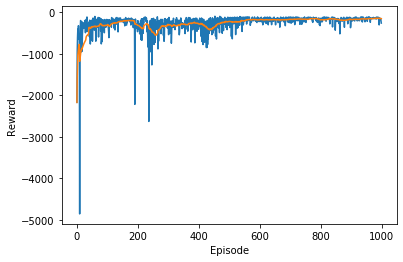

In [19]:
""" Implemented by Yinyu Jin """
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# avoid the warning message
gym.logger.set_level(40)

# hyperparameters
alpha=0.99  # reward decay
gamma = 0.99  # 
learning_rate = 0.01
hidden_layer= 24
episodes = 1000
replace_target_iter = 30
memory_size=500
batch_size = 128 # the number of data from the memory to learn every time
update_net2_steps = 20 # we update net2 every 20 steps
steps =5000
epsilon_max = 0.9
e_greedy_increment = None


class DeepQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size): 
        super (DeepQNetwork, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_actions)
        )

        # build network
        self.mls = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
   
        # initialize zero memory [s, a ,r, s_]
        self.memory = np.zeros((memory_size, state_space*2+2)) 
        
        # total learning step
        self.learn_step_counter = 0
        
        # epsilon
        self.epsilon =0 if e_greedy_increment is not None else epsilon_max
         
    def forward(self, state):
        return self.fc(state)
        
    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            out = self.forward(torch.Tensor(state))
            action = torch.argmax(out).data.item()
        else:  
            action = np.random.randint(0, env.action_space.n)
        return action
    
    def store_memory(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        self.memory[self.memory_counter%memory_size][0:2] = s
        self.memory[self.memory_counter%memory_size][2] = a
        self.memory[self.memory_counter%memory_size][3] = r
        self.memory[self.memory_counter%memory_size][4:6] = s_
        self.memory_counter +=1
        
    def learn (self):
        # check to replace target weights
        if self.learn_step_counter % replace_target_iter ==0:
            net2.load_state_dict(net.state_dict())
            
        # sample batch memory from all memory
        if self.memory_counter > memory_size: # memory size 1000, batch size 500
            sample_index = np.random.choice(memory_size, size = batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size = batch_size)
        batch_memory = torch.Tensor(self.memory[sample_index,:])

        #learn
        q = net.forward(batch_memory[:,0:2]).gather(dim=1, index=batch_memory[:,2].long().unsqueeze(1))
        q_next = net2.forward(batch_memory[:,4:6]).detach().max(1)[0].reshape(batch_size,1)
        target_q = batch_memory[:,3].unsqueeze(1) + gamma*q_next
        
        loss = net.mls(q, target_q)
        net.optimizer.zero_grad()
        loss.backward()
        net.optimizer.step()
                
    def discounted_norm_rewards (self, rewards):
        returns = np.zeros_like(rewards)
        running_add = 0
        for t in reversed (range(len(rewards))):
            running_add = running_add * gamma + rewards[t]
            returns[t] = running_add
            
        #normalized discounted rewards
        returns = (returns - np.mean(returns)) / (np.std(returns)+eps)
        return returns
    
env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(1)

np.random.seed(1)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()

all_rewards = []
running_rewards = []


net  = DeepQNetwork(state_space,action_space, hidden_layer)
net2 = DeepQNetwork(state_space,action_space, hidden_layer)

step=0
for episode in range(1000): 
    state = env.reset()
    rewards = []
    
#     for step in range(steps):
    while True:
        action = net.choose_action(state)
        new_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        # store every memory [s, a, r, s_] at each step
        net.store_memory(state,action,reward,new_state)
        state = new_state
        
        # when our memory is full
        if step > 200 and step % 10 ==0:
            net.learn()
                            
        if done: 
            returns = net.discounted_norm_rewards(rewards)
            all_rewards.append(np.sum(rewards))
            running_rewards.append(np.mean(all_rewards[-30:]))
            if episode % 100 ==0:
                print('episode:', episode, 'total reward: ', all_rewards[-1], 'running reward:', int(running_rewards[-1]))
                
            break
        step += 1
#         env.render()
        
        
plt.plot(all_rewards)
plt.plot(running_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()